
 📘 Dataset cargado con éxito.


🔍 Primeras filas del DataFrame:
   sexo_M  sexo_F  edad  gestion_educativa_Pu  gestion_educativa_Pr  \
0     1.0     0.0  18.0                   1.0                   0.0   
1     1.0     0.0  17.0                   1.0                   0.0   
2     1.0     0.0  19.0                   0.0                   1.0   
3     1.0     0.0  17.0                   1.0                   0.0   
4     0.0     1.0  17.0                   0.0                   1.0   

   region_colegio_Lima  region_colegio_Callao  region_colegio_Prov  \
0                  1.0                    0.0                  0.0   
1                  0.0                    0.0                  1.0   
2                  1.0                    0.0                  0.0   
3                  0.0                    1.0                  0.0   
4                  0.0                    0.0                  1.0   

   tipo_preparacion_Ac  tipo_preparacion2_Otr  ...  \
0                  1.0           

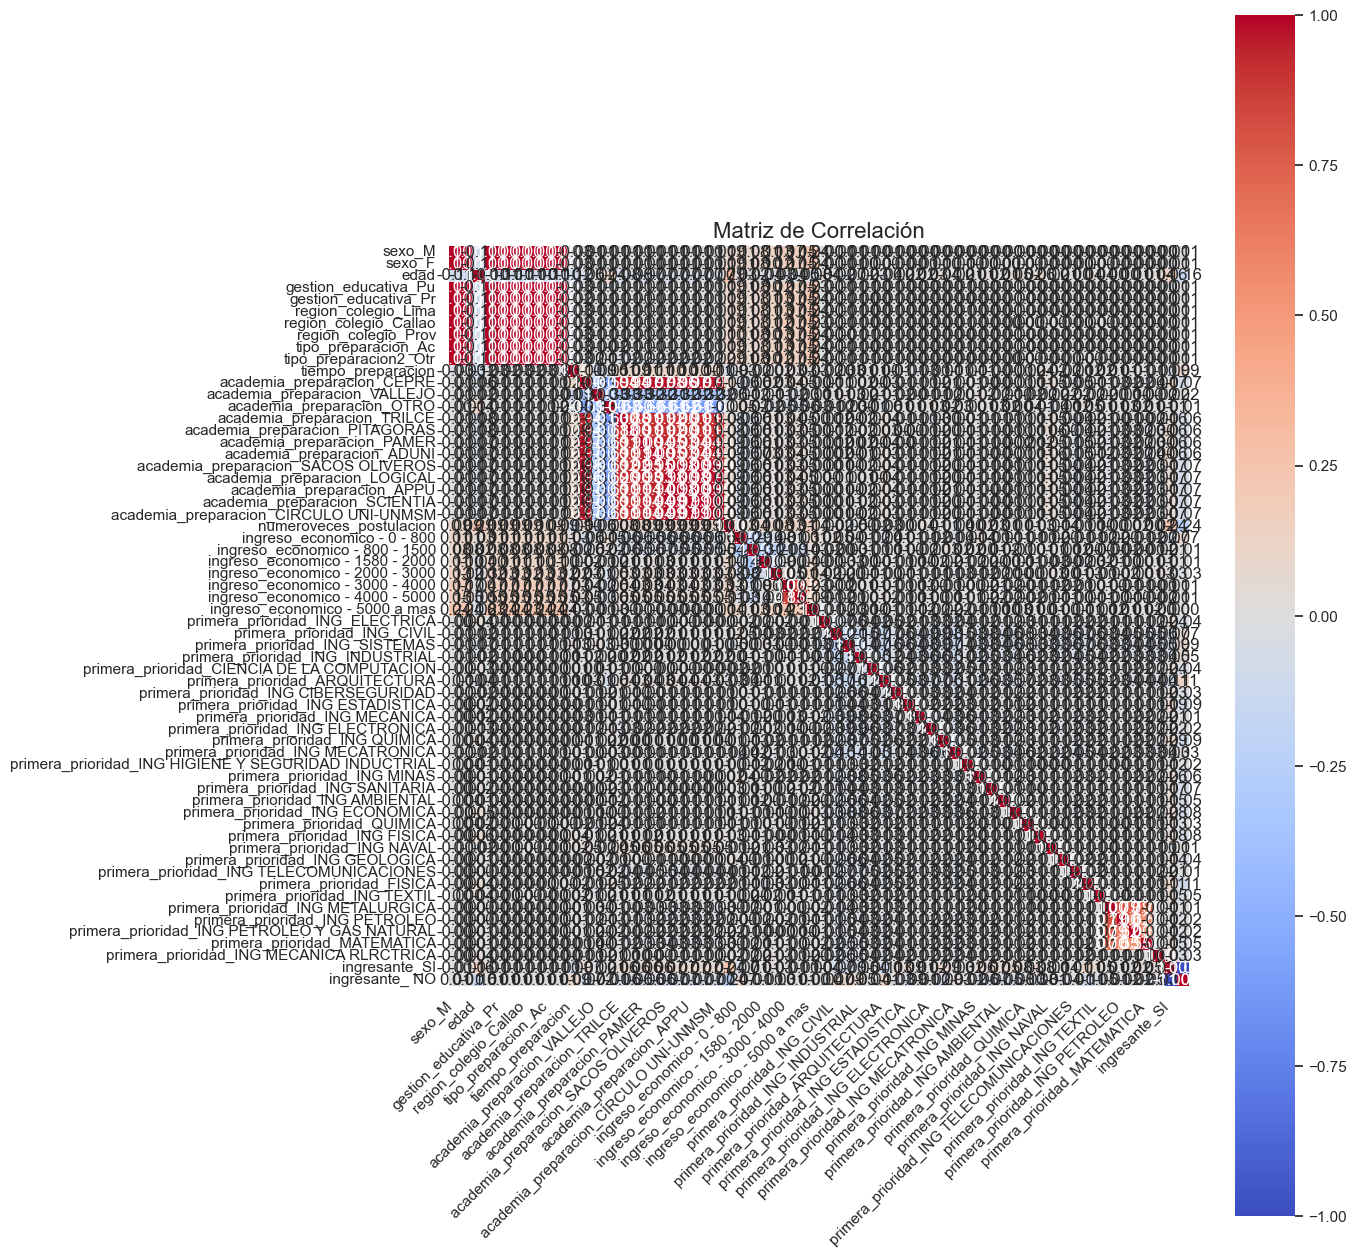

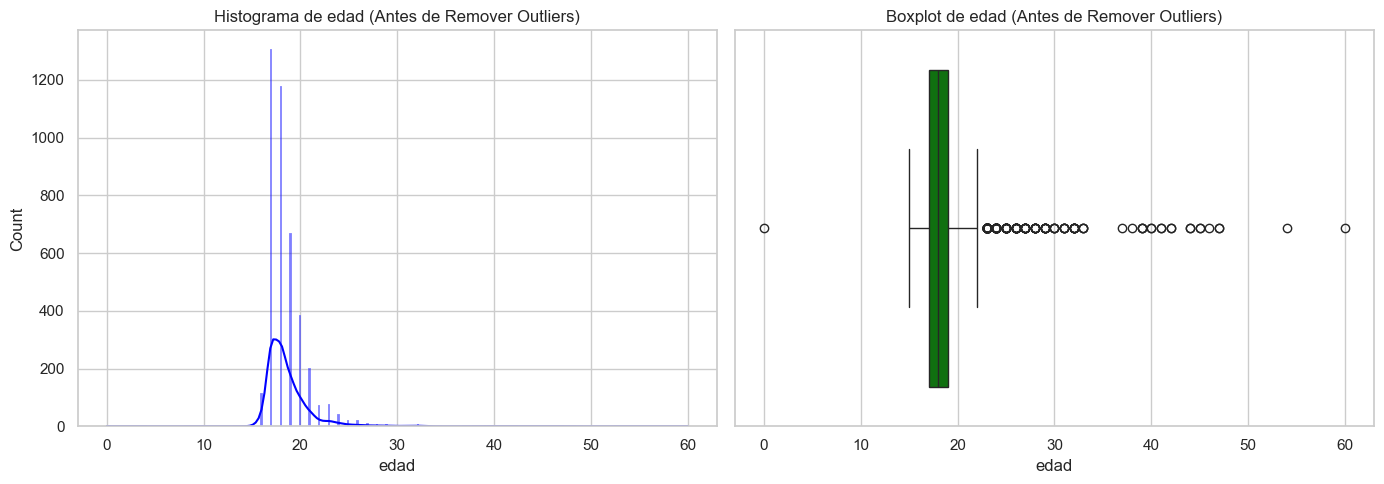

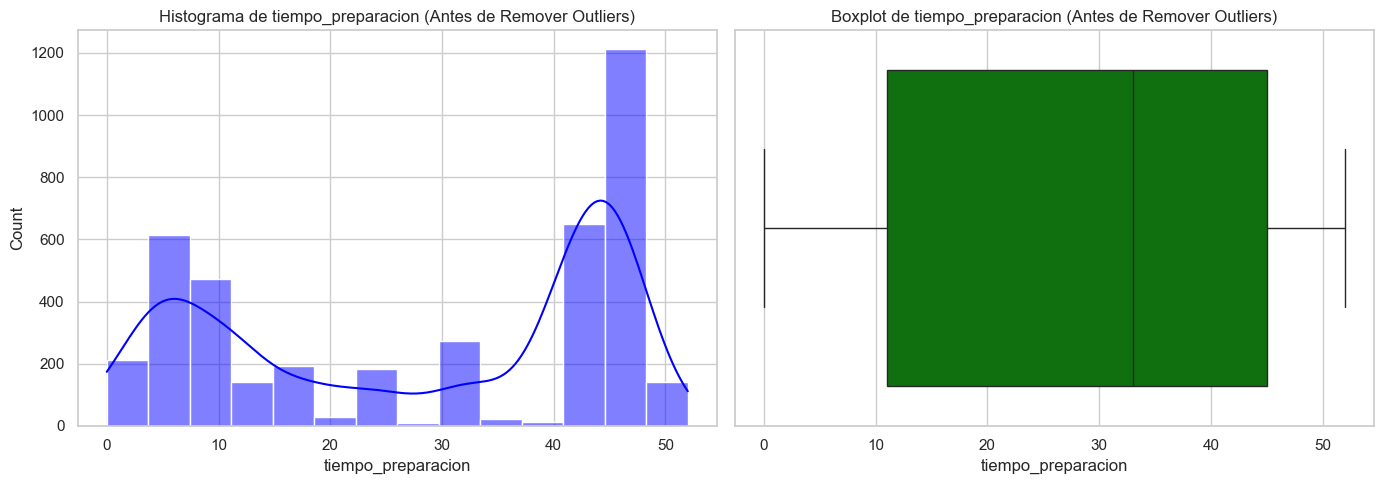

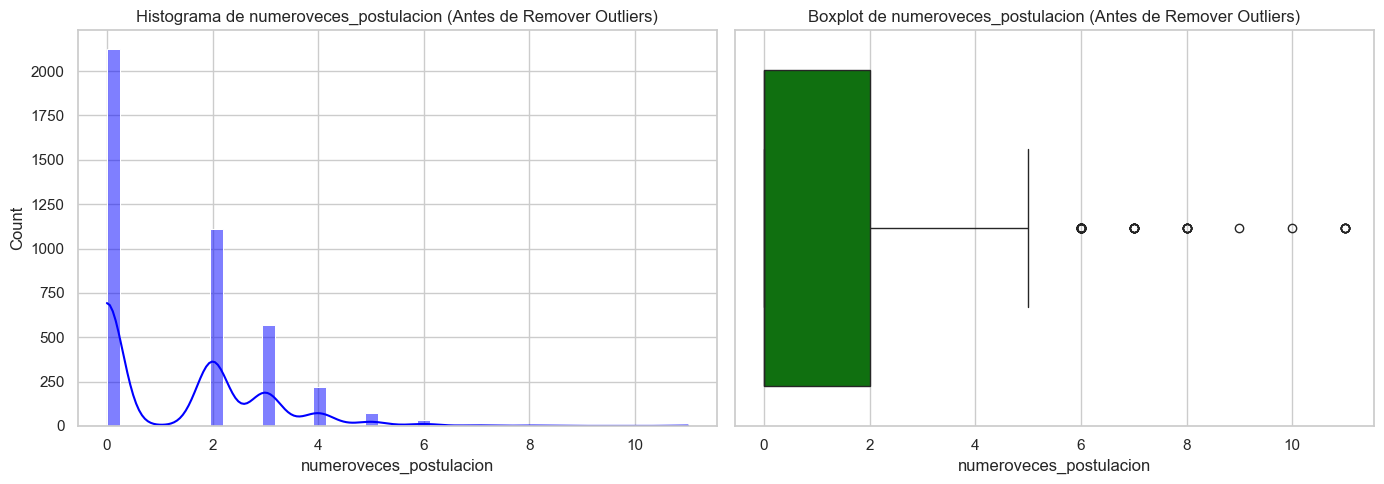


🔎 Columnas a evaluar outliers con IQR: ['edad', 'tiempo_preparacion', 'numeroveces_postulacion']

🔎 Outliers eliminados (solo en columnas relevantes):
 - Forma inicial : (4164, 62)
 - Forma final   : (3896, 62)



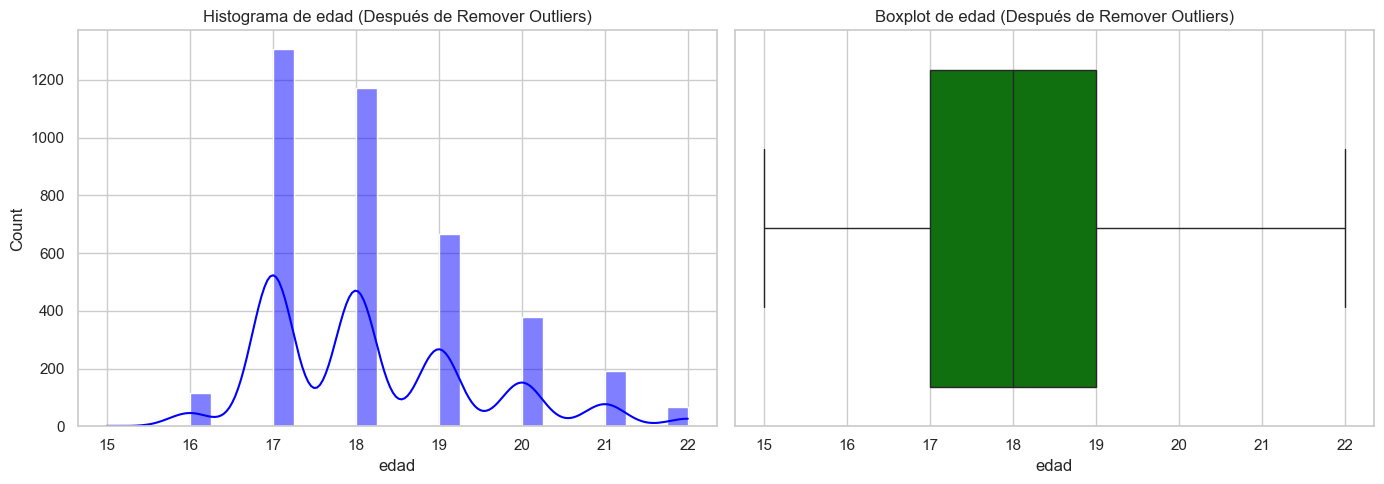

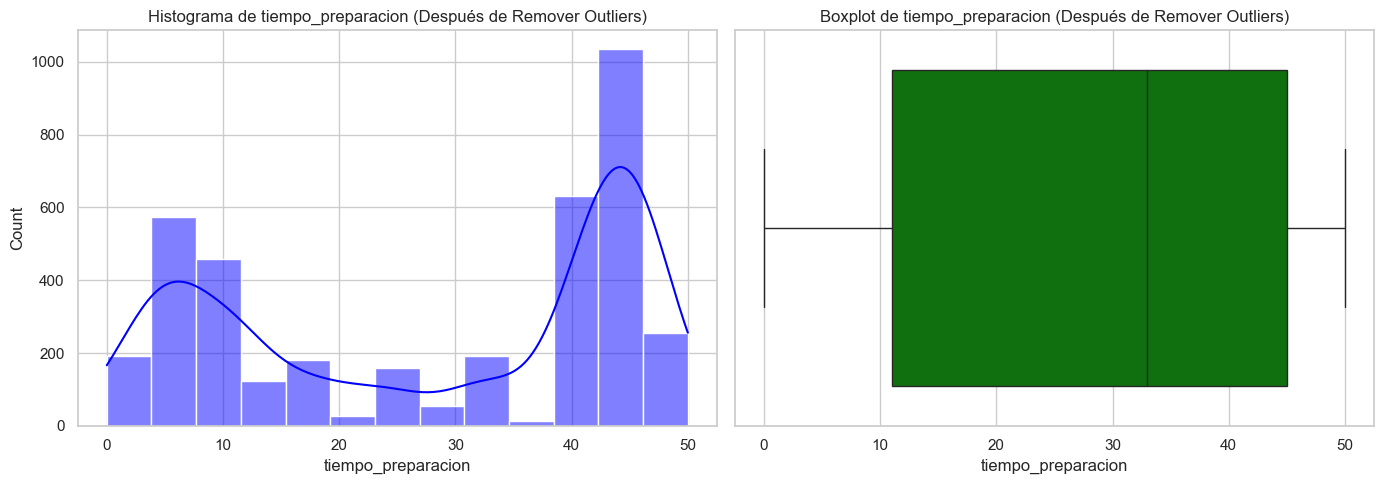

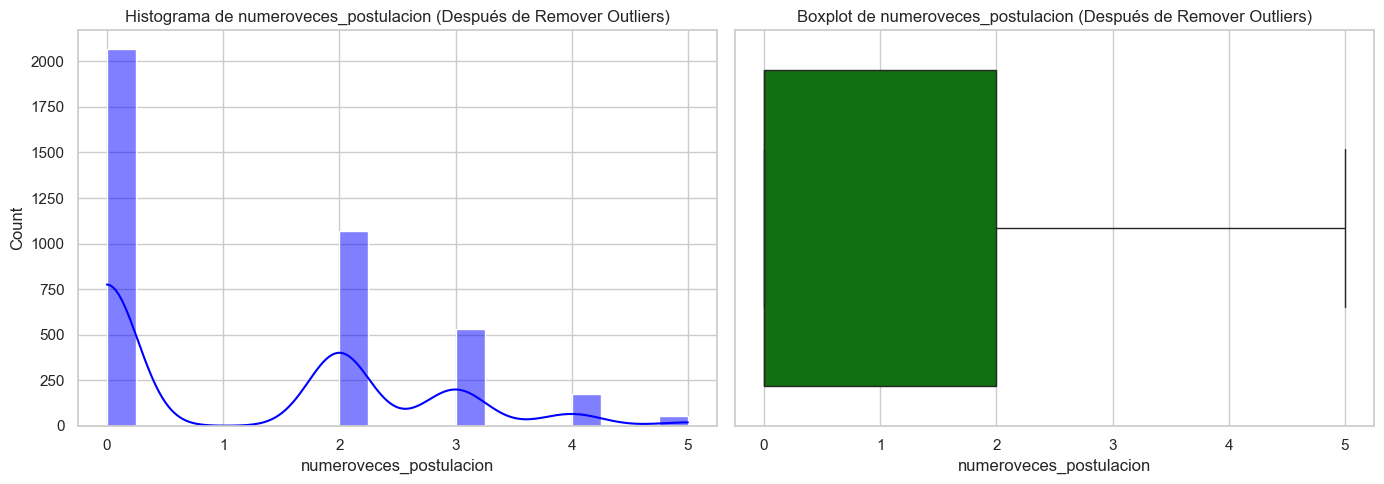

🔧 Escalado completado con StandardScaler.



C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9881 (\N{GEAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


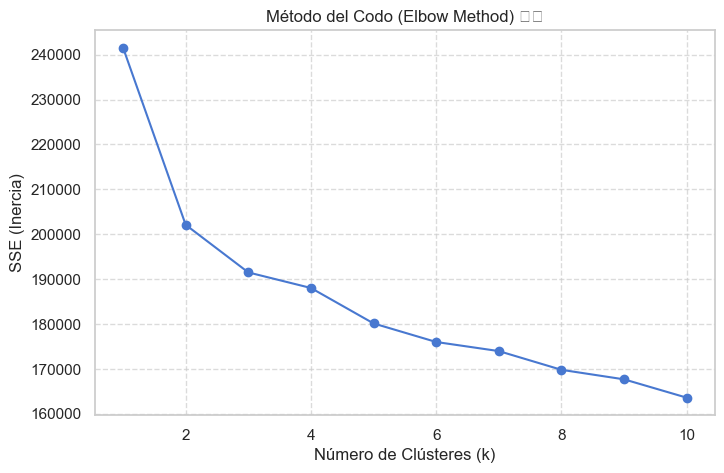

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


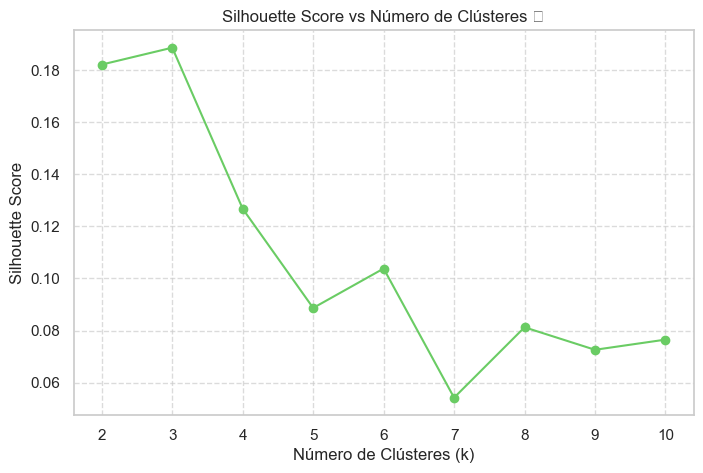

🧐 k óptimo (según Elbow) podría ser 3
🧐 k óptimo (según Silhouette) podría ser 3

✅ Número de clústeres seleccionado: 3

📊 Estadísticas descriptivas por clúster (promedio):
           sexo_M    sexo_F       edad  gestion_educativa_Pu  \
Cluster                                                        
0        0.778692  0.221308  18.224599              0.475113   
1        0.863636  0.136364  18.227273              0.454545   
2        0.740818  0.259182  18.111573              0.347886   

         gestion_educativa_Pr  region_colegio_Lima  region_colegio_Callao  \
Cluster                                                                     
0                    0.524887             0.795557               0.042781   
1                    0.545455             0.818182               0.045455   
2                    0.652114             0.789328               0.050589   

         region_colegio_Prov  tipo_preparacion_Ac  tipo_preparacion2_Otr  ...  \
Cluster                                

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


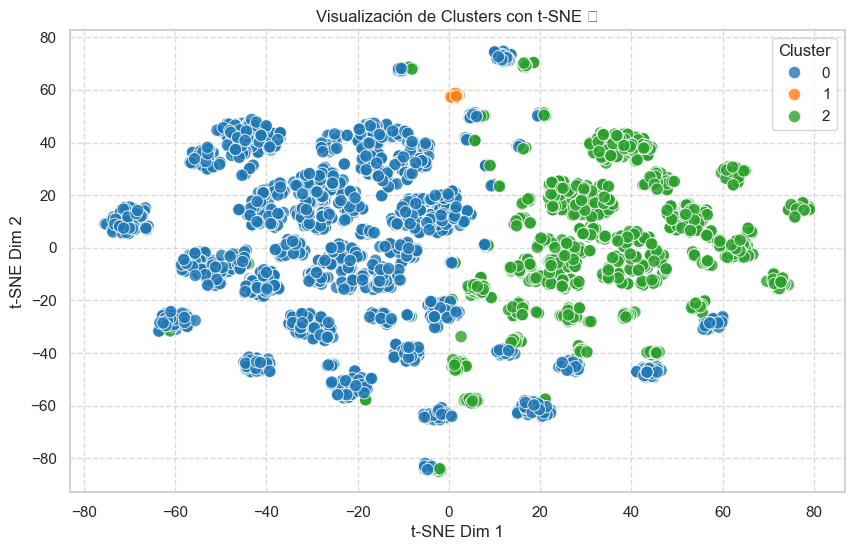

In [6]:
# =============================================================================
#       ***   PROBLEMA DE CLASIFICACIÓN (NO SUPERVISADO)   ***
# =============================================================================
# Autor      :  Martin Verastegui
# Fecha      :  12-Dic-2024
# Descripción:
#   Este script realiza un análisis exploratorio y entrena un modelo
#   de Machine Learning No Supervisado (K-Means) para la agrupación
#   de los postulantes a la UNI. Aquí se enfocan los outliers
#   únicamente en 3 columnas continuas (edad, tiempo_preparacion,
#   numeroveces_postulacion), basándose en el método IQR, y se
#   generan histogramas/boxplots antes y después de su limpieza.

# =============================================================================
# 1) Importar librerías necesarias
# =============================================================================
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesamiento y evaluación de ML
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Modelo de clustering
from sklearn.cluster import KMeans

# Métricas y reducción de dimensionalidad
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# =============================================================================
# 2) Configuración inicial
# =============================================================================
os.environ["OMP_NUM_THREADS"] = "1"   # Evita saturación de CPU
os.environ["MKL_NUM_THREADS"] = "1"

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 5)

# =============================================================================
# 3) Carga del Dataset
# =============================================================================
file_path = "Postulantes_UNI.csv"  # Ajusta la ruta/nombre según tu entorno

try:
    df = pd.read_csv(file_path, encoding='latin-1')
    print("\n===========================================================")
    print(" 📘 Dataset cargado con éxito.")
    print("===========================================================\n")
except FileNotFoundError:
    print("❌ Error: No se encontró el archivo. Verifica la ruta.")
    exit()
except UnicodeDecodeError:
    print("⚠️ Advertencia: Codificación problemática. Intentando con 'utf-8'.")
    df = pd.read_csv(file_path, encoding='utf-8')
except Exception as e:
    print(f"❌ Error inesperado: {e}")
    exit()

# =============================================================================
# 4) Análisis Exploratorio Inicial
# =============================================================================
print("\n🔍 Primeras filas del DataFrame:")
print(df.head(), "\n")

print("📊 Información del dataset:")
print(df.info(), "\n")

print("📈 Estadísticas descriptivas (variables numéricas):")
print(df.describe(), "\n")

print("🔎 Valores nulos por columna:")
print(df.isnull().sum(), "\n")

# =============================================================================
# 5) Limpieza de Datos y Preprocesamiento
# =============================================================================
# 5.1 Reemplazar caracteres faltantes ('?') por NaN
df.replace('?', pd.NA, inplace=True)

# 5.2 Separar columnas numéricas y categóricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

# 5.3 Manejo de valores nulos (numéricos) -> mediana
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# 5.4 Codificación de variables categóricas con LabelEncoder
label_encoders = {}
if len(cat_cols) > 0:
    print("🔄 Codificando variables categóricas...")
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    print(f"✔️ Columnas categóricas codificadas: {list(cat_cols)}\n")
else:
    print("✔️ No se encontraron columnas categóricas para codificar.\n")


# =============================================================================
#  Visualización de la Matriz de Correlación 
# =============================================================================
# Escalado de Características
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)  # Escalar los datos
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)  # Crear un DataFrame escalado

# Visualización de la Matriz de Correlación
plt.figure(figsize=(14, 14))  # Aumentar el tamaño
sns.heatmap(
    scaled_df.corr(),
    annot=True,     # Mostrar valores numéricos
    fmt='.2f',
    cmap='coolwarm',
    square=True     # Mantener celdas cuadradas
)
plt.title('Matriz de Correlación', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)  # Mantén las etiquetas verticales
plt.tight_layout()  # Ajusta los márgenes para que todo quepa
plt.show()


# =============================================================================
# 6) Visualización previa de la Distribución en 3 Columnas (antes de outliers)
# =============================================================================
# Nos interesa solo: edad, tiempo_preparacion, numeroveces_postulacion
cols_of_interest = ["edad", "tiempo_preparacion", "numeroveces_postulacion"]

for col in cols_of_interest:
    if col in df.columns:
        plt.figure(figsize=(14, 5))
        
        # Histograma
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, color='blue')
        plt.title(f"Histograma de {col} (Antes de Remover Outliers)")
        
        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='green')
        plt.title(f"Boxplot de {col} (Antes de Remover Outliers)")
        
        plt.tight_layout()
        plt.show()

# =============================================================================
# 7) Función para Detección de Outliers con IQR
# =============================================================================
def find_outliers_IQR(series, lower_quantile=0.25, upper_quantile=0.75, factor=1.5):
    Q1 = series.quantile(lower_quantile)
    Q3 = series.quantile(upper_quantile)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return (series < lower) | (series > upper)

# =============================================================================
# 8) Aplicar Eliminación de Outliers SOLO a Columnas de Interés
# =============================================================================
initial_shape = df.shape
print(f"\n🔎 Columnas a evaluar outliers con IQR: {cols_of_interest}")

for col in cols_of_interest:
    if col in df.columns:
        outlier_mask = find_outliers_IQR(df[col], lower_quantile=0.25, upper_quantile=0.75, factor=1.5)
        df = df[~outlier_mask]  # Eliminamos filas que sean outliers en esa columna

final_shape = df.shape
print("\n🔎 Outliers eliminados (solo en columnas relevantes):")
print(f" - Forma inicial : {initial_shape}")
print(f" - Forma final   : {final_shape}\n")

# =============================================================================
# 9) Visualización Posterior de la Distribución en esas 3 Columnas
# =============================================================================
for col in cols_of_interest:
    if col in df.columns:
        plt.figure(figsize=(14, 5))
        
        # Histograma
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, color='blue')
        plt.title(f"Histograma de {col} (Después de Remover Outliers)")
        
        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], color='green')
        plt.title(f"Boxplot de {col} (Después de Remover Outliers)")
        
        plt.tight_layout()
        plt.show()

# =============================================================================
# 10) Escalado de Características (StandardScaler)
# =============================================================================
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

print("🔧 Escalado completado con StandardScaler.\n")

# =============================================================================
# 11) Elección del Número de Clústeres (K-Means)
# =============================================================================
# A) Método del Codo (Elbow Method)
SSE = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    km.fit(scaled_df)
    SSE.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, SSE, marker='o', color='b')
plt.title('Método del Codo (Elbow Method) ⚙️')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('SSE (Inercia)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# B) Coeficiente de Silhouette
silhouette_scores = []
K_range_sil = range(2, 11)
for k in K_range_sil:
    km_temp = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels_temp = km_temp.fit_predict(scaled_df)
    sil_score = silhouette_score(scaled_df, labels_temp)
    silhouette_scores.append(sil_score)

plt.figure(figsize=(8, 5))
plt.plot(K_range_sil, silhouette_scores, marker='o', color='g')
plt.title('Silhouette Score vs Número de Clústeres 🌟')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

optimal_k_elbow = 3   # Ejemplo: Observando la curva del codo
optimal_k_sil = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"🧐 k óptimo (según Elbow) podría ser {optimal_k_elbow}")
print(f"🧐 k óptimo (según Silhouette) podría ser {optimal_k_sil}\n")

# Seleccionamos un valor final 
optimal_k = 3
print(f"✅ Número de clústeres seleccionado: {optimal_k}\n")

# =============================================================================
# 12) Entrenamiento del Modelo K-Means
# =============================================================================
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
labels = kmeans.fit_predict(scaled_df)

# Agregamos la columna 'Cluster' al DataFrame original
df['Cluster'] = labels

# =============================================================================
# 13) Análisis de los Clústeres
# =============================================================================
cluster_stats = df.groupby('Cluster').mean()
print("📊 Estadísticas descriptivas por clúster (promedio):")
print(cluster_stats, "\n")

centroids = kmeans.cluster_centers_
order_centroids = centroids.argsort()[:, ::-1]

important_features = {}
for i in range(optimal_k):
    important_features[i] = [df.columns[ind] for ind in order_centroids[i, :10]]

print("🔑 Características más importantes por clúster:")
for cluster, features in important_features.items():
    print(f"  Clúster {cluster}: {features}")
print()

# =============================================================================
# 14) Visualización con t-SNE 
# =============================================================================
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_df)

df_tsne = pd.DataFrame({
    't-SNE1': tsne_result[:, 0],
    't-SNE2': tsne_result[:, 1],
    'Cluster': labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_tsne,
    x='t-SNE1',
    y='t-SNE2',
    hue='Cluster',
    palette='tab10',
    s=80,
    alpha=0.8
)
plt.title('Visualización de Clusters con t-SNE 🌀')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Cluster')
plt.show()

